In [ ]:
# !pip install interpret
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [ ]:
import shap
shap.initjs()

In [ ]:
path = "healthcare-dataset-stroke-data.csv"
dt = pd.read_csv(path)
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [ ]:
class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols],
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)

        # Drop id as it is not relevant
        # self.data.drop(["id"], axis=1, inplace=True)

        # Standardization
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)

    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over

In [ ]:
data_loader = DataLoader()
data_loader.load_dataset()
data = data_loader.data

# %% Show head
print(data.shape)
data.head()

(5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# Show preprocessed dataframe
data_loader.preprocess_data()
data_loader.data.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,67.0,0,1,228.69,36.6,1
1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,61.0,0,0,202.21,0.0,1
2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,80.0,0,1,105.92,32.5,1
3,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,49.0,0,0,171.23,34.4,1
4,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,79.0,1,0,174.12,24.0,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap

In [ ]:
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

(7778, 21)
(1022, 21)


## Building classifier model

In [ ]:
# Fit blackbox model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.5312473277101878
Accuracy 0.9422700587084148


## Generate explainer and SHAP values

In [ ]:
# %% Create SHAP explainer
explainer = shap.TreeExplainer(model)

In [ ]:
idx = 111
print(X_test.iloc[idx])
print()
print(y_test.iloc[idx])

gender_Female                       1.00
gender_Male                         0.00
gender_Other                        0.00
ever_married_No                     0.00
ever_married_Yes                    1.00
work_type_Govt_job                  1.00
work_type_Never_worked              0.00
work_type_Private                   0.00
work_type_Self-employed             0.00
work_type_children                  0.00
Residence_type_Rural                1.00
Residence_type_Urban                0.00
smoking_status_Unknown              0.00
smoking_status_formerly smoked      0.00
smoking_status_never smoked         1.00
smoking_status_smokes               0.00
age                                52.00
hypertension                        0.00
heart_disease                       0.00
avg_glucose_level                 183.87
bmi                                26.20
Name: 2641, dtype: float64

0


In [ ]:
shap_values = explainer.shap_values(X_test.iloc[idx])
shap_values = shap_values[:, 1]
shap_values

array([ 1.10897617e-02,  8.62425709e-03,  5.23245292e-09,  8.19972540e-03,
        1.25529846e-02, -2.00975496e-02,  4.70690408e-05, -1.51695688e-02,
       -9.88291511e-06,  3.96857632e-03, -4.71450168e-03, -1.30432579e-03,
        2.53428794e-03, -1.24017775e-02, -2.23554045e-02, -8.41766458e-03,
       -2.06332380e-01, -2.11086650e-02, -6.06151829e-03,  2.35447368e-02,
       -6.34817113e-02])

In [ ]:
shap.initjs()
# Force plot
prediction = model.predict(X_test[idx:idx+1])[0]

print(f"Actual output: {y_test.iloc[idx]}")
print(f"Predicted output: {prediction}")
print("")

shap.force_plot(explainer.expected_value[1],
                shap_values,
                X_test.iloc[idx]) # for values

Actual output: 0
Predicted output: 0



In [ ]:
idx = 39
print(y_test.iloc[idx])
X_test.iloc[idx]

1


gender_Female                      1.00
gender_Male                        0.00
gender_Other                       0.00
ever_married_No                    1.00
ever_married_Yes                   0.00
work_type_Govt_job                 0.00
work_type_Never_worked             0.00
work_type_Private                  1.00
work_type_Self-employed            0.00
work_type_children                 0.00
Residence_type_Rural               0.00
Residence_type_Urban               1.00
smoking_status_Unknown             1.00
smoking_status_formerly smoked     0.00
smoking_status_never smoked        0.00
smoking_status_smokes              0.00
age                               77.00
hypertension                       0.00
heart_disease                      0.00
avg_glucose_level                 81.32
bmi                                0.00
Name: 183, dtype: float64

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[idx])
shap_values = shap_values[:, 1]
shap_values

array([ 9.76385964e-03,  1.40896371e-02,  8.33443703e-09,  1.70890375e-02,
        3.30725608e-02, -9.14217441e-03,  2.27384019e-04, -1.72799640e-04,
        7.04890800e-03,  1.02927393e-02,  8.62412724e-03,  2.52925694e-03,
       -1.23850189e-02, -1.79077301e-03, -1.36791407e-03,  3.66682363e-03,
        2.33928134e-01, -4.84431143e-03, -4.37312441e-03, -9.95608817e-02,
        1.62410975e-01])

In [ ]:
shap.initjs()
# Force plot
prediction = model.predict(X_test[idx:idx+1])[0]

print(f"Actual output: {y_test.iloc[idx]}")
print(f"Predicted output: {prediction}")
print("")

shap.force_plot(explainer.expected_value[1],
                shap_values,
                X_test.iloc[idx]) # for values

Actual output: 1
Predicted output: 1



### Wrong Predictions

In [ ]:
lst = []
for i in range(len(y_pred)):
  if y_pred[i] != y_test.iloc[i]:
    lst.append(i)
print(lst)

[9, 12, 13, 24, 28, 78, 82, 94, 102, 118, 123, 136, 173, 191, 194, 207, 229, 240, 251, 283, 304, 310, 349, 351, 382, 391, 404, 433, 452, 474, 477, 495, 511, 537, 545, 559, 561, 564, 584, 589, 702, 716, 723, 731, 733, 788, 799, 800, 819, 826, 829, 844, 858, 924, 945, 961, 974, 986, 1016]


In [ ]:
idx = 12
print(y_test.iloc[idx])
X_test.iloc[idx]

1


gender_Female                       1.00
gender_Male                         0.00
gender_Other                        0.00
ever_married_No                     0.00
ever_married_Yes                    1.00
work_type_Govt_job                  0.00
work_type_Never_worked              0.00
work_type_Private                   1.00
work_type_Self-employed             0.00
work_type_children                  0.00
Residence_type_Rural                0.00
Residence_type_Urban                1.00
smoking_status_Unknown              0.00
smoking_status_formerly smoked      0.00
smoking_status_never smoked         1.00
smoking_status_smokes               0.00
age                                51.00
hypertension                        0.00
heart_disease                       0.00
avg_glucose_level                 165.31
bmi                                 0.00
Name: 78, dtype: float64

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[idx])
shap_values = shap_values[:, 1]
shap_values

array([-9.57277145e-04, -4.52416650e-05,  5.83964343e-09,  4.36011765e-03,
        9.24477100e-03, -1.26153264e-02,  4.05028355e-05, -1.04411570e-02,
       -2.93110366e-03,  1.31075432e-03, -9.24592356e-03, -9.81092692e-03,
       -1.22377949e-02, -3.62417201e-02, -4.40309116e-02, -1.04997846e-02,
       -2.30165414e-01, -2.11976650e-02, -6.60988246e-03, -5.75795360e-02,
       -2.12400328e-02])

In [ ]:
shap.initjs()
# Force plot
prediction = model.predict(X_test[idx:idx+1])[0]

print(f"Actual output: {y_test.iloc[idx]}")
print(f"Predicted output: {prediction}")
print("")

shap.force_plot(explainer.expected_value[1],
                shap_values,
                X_test.iloc[idx]) # for values

Actual output: 1
Predicted output: 0



In [ ]:
# Feature summary
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,plot_type = "bar",)

## Neural Network 1

In [ ]:
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

In [ ]:
# load pre-trained model and choose two images to explain
model = ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
# preprocess input image based in the resnet50 archiecture
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

In [ ]:
X, y = shap.datasets.imagenet50()

In [ ]:
# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

class_names

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [ ]:
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [04:20, 130.02s/it]


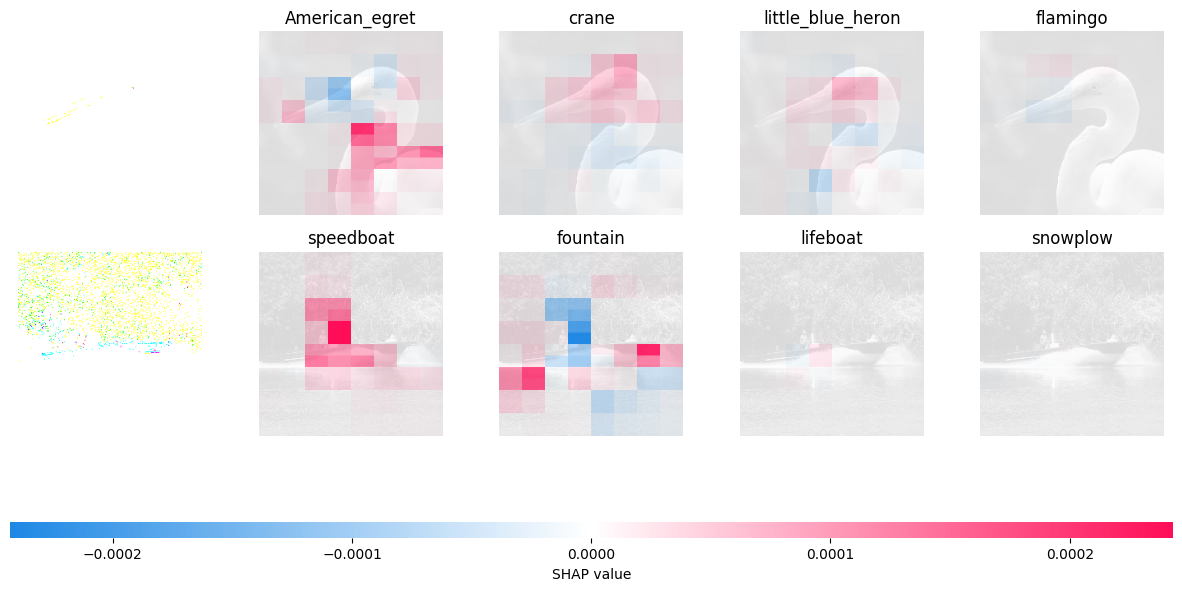

In [ ]:
# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3],
                        max_evals=500,
                        batch_size=50,
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [04:16<01:06, 66.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [06:34<00:00, 95.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:52, 133.21s/it]


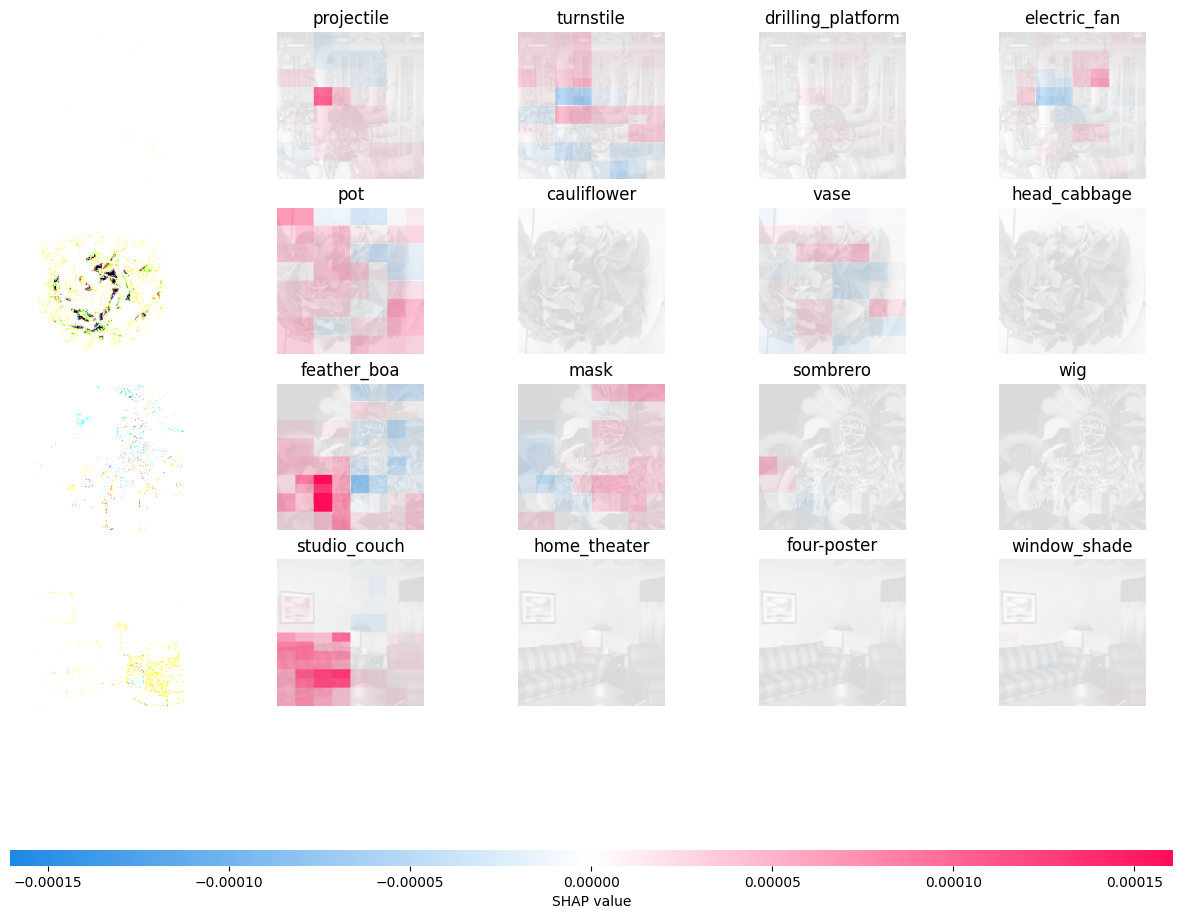

In [ ]:
# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[5:9],
                        max_evals=500,
                        batch_size=50,
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

## Neural Network 2

In [ ]:
import keras
import numpy as np
from keras import layers
from keras.utils import to_categorical

import shap

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 128
epochs = 3

model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)         

In [ ]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)

# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[0:5])

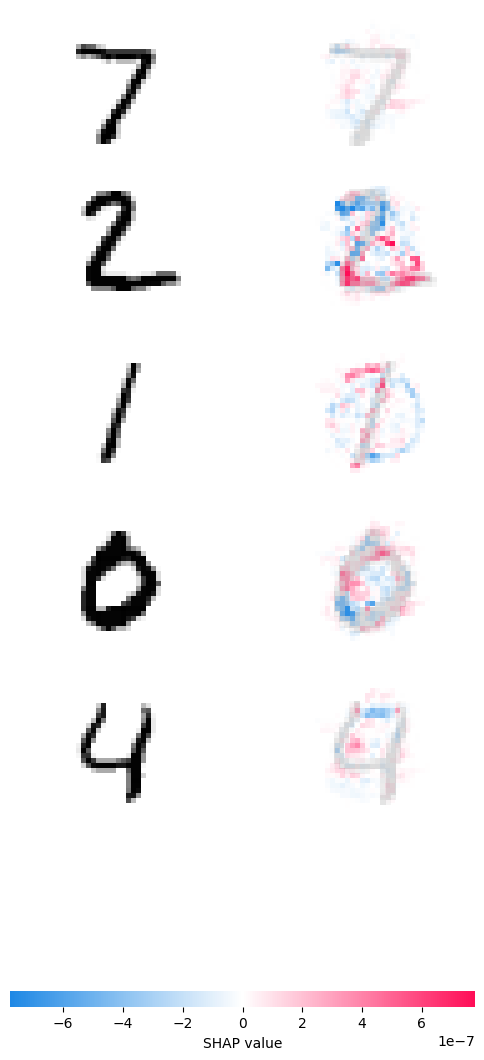

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[0:5])

## Neural Network 3

In [ ]:
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    concatenate,
)
from keras.layers import Embedding
from keras.models import Model
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k, dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=7
)

In [ ]:
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [ ]:
y_display

array([False, False, False, ..., False, False,  True])

In [ ]:
# build model
input_els = []
encoded_els = []
for k, dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max() + 1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss="binary_crossentropy")
regression.fit(
    [X_train[k].values for k, t in dtypes],
    y_train,
    epochs=30,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k, t in dtypes], y_valid),
)

Epoch 1/30
51/51 [==============================] - 3s 15ms/step - loss: 1.7042 - val_loss: 0.5278
Epoch 2/30
51/51 [==============================] - 0s 9ms/step - loss: 1.4547 - val_loss: 0.4870
Epoch 3/30
51/51 [==============================] - 1s 12ms/step - loss: 1.3092 - val_loss: 0.5385
Epoch 4/30
51/51 [==============================] - 0s 10ms/step - loss: 1.4008 - val_loss: 0.5151
Epoch 5/30
51/51 [==============================] - 0s 9ms/step - loss: 1.2724 - val_loss: 0.5042
Epoch 6/30
51/51 [==============================] - 1s 11ms/step - loss: 1.2238 - val_loss: 0.4819
Epoch 7/30
51/51 [==============================] - 1s 12ms/step - loss: 1.1751 - val_loss: 0.5480
Epoch 8/30
51/51 [==============================] - 0s 10ms/step - loss: 1.1964 - val_loss: 0.5318
Epoch 9/30
51/51 [==============================] - 0s 6ms/step - loss: 1.1730 - val_loss: 0.4629
Epoch 10/30
51/51 [==============================] - 0s 6ms/step - loss: 1.1148 - val_loss: 0.4516
Epoch 11/30
5

In [ ]:
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [ ]:
explainer = shap.KernelExplainer(f, X.iloc[:100,:])


4/4 [==============================] - 0s 3ms/step


In [ ]:
X.iloc[3,:]

Age                1.057031
Workclass          4.000000
Education-Num     -1.197440
Marital Status     2.000000
Occupation         6.000000
Relationship       4.000000
Race               2.000000
Sex                1.000000
Capital Gain      -0.145918
Capital Loss      -0.216656
Hours per week    -0.035429
Country           39.000000
Name: 3, dtype: float64

In [ ]:
idx = 3
shap_values = explainer.shap_values(X.iloc[idx,:])
shap.initjs()
print("Output : ", y[idx])
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[idx,:])

6475/6475 [==============================] - 13s 2ms/step


Output :  False


In [ ]:
shap_values

array([ 2.25459854e-01, -8.36826949e-04, -3.30435946e-01,  2.54077478e-04,
       -1.77664927e-01,  9.10817162e-02, -2.06301530e-02, -1.27158534e-03,
       -2.47130568e-02, -1.19211469e-02,  1.82861334e-02,  6.22688001e-04])

In [ ]:
idx = 16264
shap_values = explainer.shap_values(X.iloc[idx,:])
shap.initjs()
print("Output : ", y[idx])
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[idx,:])

6475/6475 [==============================] - 13s 2ms/step


Output :  True


In [ ]:
shap_values50 = explainer.shap_values(X.iloc[280:330, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

1563/1563 [==============================] - 4s 2ms/step


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330, :])

In [ ]:
import numpy as np
print(np.sum(shap_values))

0.6692267213482409
